# Module 7: 特徵選擇 - 5. 綜合案例：乳癌資料集的特徵選擇與降維

## 學習目標
- 在一個真實的二元分類資料集（乳癌資料集）上，綜合應用所學的特徵選擇（過濾法、包裹法、嵌入法）和降維（PCA）技術。
- 學習如何建立一個基準模型，並與不同特徵工程策略下的模型效能進行比較。
- 評估和分析不同特徵工程方法對模型準確率、複雜度及可解釋性的影響。
- 掌握在實際問題中，如何系統性地選擇最適合的特徵工程策略。

## 導論：如何從高維資料中精煉出預測力量？

在真實世界的資料科學問題中，我們經常面對包含大量特徵的複雜資料集。這些特徵中有些可能是高度相關的，有些則可能包含噪音或冗餘資訊。如何在這樣的資料中，抽絲剝繭，找出最具預測價值的「黃金特徵」，是提升機器學習模型效能與解釋性的關鍵步驟。本案例研究正是為了解決這一挑戰而設計。

我們將使用著名的 **乳癌資料集 (Breast Cancer Wisconsin Dataset)**，這是一個典型的二元分類問題：根據細胞核的形態學特徵，判斷腫瘤是良性還是惡性。這個資料集包含 30 個連續數值特徵，是演示不同特徵選擇和降維技術的理想場景，因為特徵數量適中，且特徵之間存在一定的相關性。

本章的目標不僅僅是應用這些技術，更是要**系統性地比較**過濾法、包裹法、嵌入法和主成分分析 (PCA) 這四種不同策略在乳癌預測任務中的實際效果。透過訓練一個基準模型，並將其性能與應用了不同特徵工程方法的模型進行對比，我們將獲得對每種方法優缺點更深刻的實務理解，並學習如何在實際專案中做出明智的特徵工程決策。

---

## 1. 載入套件與資料

我們首先載入必要的 Python 套件，並準備乳癌資料集。為了確保比較的公平性，我們會將資料集切分為訓練集和測試集，並對數值特徵進行標準化處理。標準化對於許多機器學習模型（特別是基於梯度下降的模型）至關重要，可以幫助模型更快收斂，並避免某些特徵因數值範圍過大而主導模型學習過程。

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # 確保一致性

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Models and Feature Selection tools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


# 設定繪圖樣式
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 載入乳癌資料集
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names) # 特徵資料
y = pd.Series(data.target, name='target') # 目標變數：0為惡性，1為良性

print("乳癌資料集載入成功！")
print(f"原始資料集形狀 (樣本數, 特徵數): {X.shape}")
print("原始特徵名稱：")
print(X.columns.tolist())

# 切分訓練集與測試集
# stratify=y 確保訓練集和測試集中目標類別的比例與原始數據集保持一致
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\n資料集切分完成！")
print(f"訓練集形狀: {X_train.shape}")
print(f"測試集形狀: {X_test.shape}")

# 資料標準化 (對於大多數機器學習模型，特別是基於距離和梯度的模型很重要)
print("\n正在進行資料標準化...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 為了方便後續操作，將 scaled data 轉回 DataFrame，保留欄位名稱以便追蹤
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("資料標準化完成！")
print("標準化後訓練集前五筆：")
display(X_train_scaled.head())



Matplotlib and Seaborn styles configured.
乳癌資料集載入成功！
原始資料集形狀 (樣本數, 特徵數): (569, 30)
原始特徵名稱：
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

資料集切分完成！
訓練集形狀: (398, 30)
測試集形狀: (171, 30)

正在進行資料標準化...
資料標準化完成！
標準化後訓練集前五筆：


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.709821,-0.258417,-0.637396,-0.711996,1.628430,0.847289,0.166501,0.196420,0.542716,1.347151,...,-0.600068,-0.065867,-0.565662,-0.622613,2.019222,0.186202,0.180187,0.400933,-0.414074,0.445223
1,-0.830331,2.231127,-0.874980,-0.779081,-1.597569,-1.267717,-1.086471,-1.243232,-2.658543,-1.052699,...,-0.897361,1.975153,-0.949574,-0.779331,-1.747652,-1.229372,-1.258947,-1.692788,-2.095723,-1.323417
2,-1.011097,-0.227270,-1.035172,-0.911780,-1.077779,-1.098096,-0.841650,-0.955767,2.023790,-0.688547,...,-1.099685,-0.396544,-1.122706,-0.909132,-1.515009,-1.165663,-1.078897,-1.364240,-0.354125,-0.886645
3,-0.382721,-0.111581,-0.408966,-0.453660,0.072810,-0.443255,-0.756276,-0.782409,-0.163916,-0.120413,...,-0.519552,0.027482,-0.575148,-0.531239,-0.108556,-0.445414,-0.692056,-0.463762,-0.284953,-0.622794
4,-0.804508,-1.401961,-0.810071,-0.773196,0.191319,-0.507801,-0.685397,-0.530392,-0.128228,-0.001311,...,-0.814779,-1.524644,-0.858265,-0.747633,0.156312,-0.647239,-0.683022,-0.398999,-0.301862,-0.210724


## 2. 基準模型建立與評估

在應用任何特徵工程技術之前，我們首先建立一個 **基準模型 (Baseline Model)**。這個模型將使用所有原始（或僅標準化後的）特徵進行訓練。它的性能將作為一個重要的參考點，用於衡量後續特徵工程方法所帶來的提升或影響。

我們選擇 **邏輯回歸 (Logistic Regression)** 作為評估模型，因為它是一個簡單且廣泛使用的分類模型，且其性能對於特徵選擇的效果比較敏感。

In [17]:
lr_base = LogisticRegression(solver='liblinear', random_state=42) # solver='liblinear' 適用於小資料集和L1/L2懲罰
lr_base.fit(X_train_scaled, y_train)
y_pred_base = lr_base.predict(X_test_scaled)
acc_base = accuracy_score(y_test, y_pred_base)

print(f"基準模型 (使用全部 {X_train.shape[1]} 個特徵) 的準確率: {acc_base:.4f}")

# 儲存結果以供後續比較
results = {'Baseline (All Features)': acc_base} # 更新鍵名以更清晰


基準模型 (使用全部 30 個特徵) 的準確率: 0.9883


**討論**：

基準模型的準確率為我們提供了一個出發點。任何有效的特徵工程方法都應該能夠保持或超越這個基準性能，同時可能達到特徵數量的減少或模型解釋性的提升。如果特徵工程後模型性能下降，則需要重新審視所選策略。

## 3. 過濾法 (Filter Method) - `SelectKBest` 與 ANOVA F-檢定

過濾法根據特徵本身的統計特性來評估其重要性，獨立於任何機器學習模型。我們將使用 `SelectKBest` 搭配 ANOVA F-value (`f_classif`) 來選擇與目標變數最相關的特徵。`f_classif` 適用於數值特徵和類別目標變數的情況，它會計算每個特徵的 F-值，F-值越大，表示該特徵對區分不同類別的影響越大。我們將選擇得分最高的前 10 個特徵作為示例。

In [18]:
print("正在應用過濾法 (SelectKBest with f_classif)...")
# 選擇 k=10 個最佳特徵。此處應在標準化後的訓練集上擬合。
k_best = SelectKBest(score_func=f_classif, k=10)
k_best.fit(X_train_scaled, y_train)

# 獲取選擇的特徵的布林遮罩，並從原始特徵名稱中選出
selected_features_filter = X_train_scaled.columns[k_best.get_support()]
print("過濾法選擇的特徵:")
print(selected_features_filter.tolist())

# 轉換訓練集和測試集，只保留選中的特徵
X_train_filter = k_best.transform(X_train_scaled)
X_test_filter = k_best.transform(X_test_scaled)

# 在選擇的特徵上訓練邏輯回歸模型
lr_filter = LogisticRegression(solver='liblinear', random_state=42)
lr_filter.fit(X_train_filter, y_train)
y_pred_filter = lr_filter.predict(X_test_filter)
acc_filter = accuracy_score(y_test, y_pred_filter)

print(f"\n過濾法 (選擇 {X_train_filter.shape[1]} 個特徵) 的準確率: {acc_filter:.4f}")
results['Filter (k=10)'] = acc_filter



正在應用過濾法 (SelectKBest with f_classif)...
過濾法選擇的特徵:
['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']

過濾法 (選擇 10 個特徵) 的準確率: 0.9357


**討論**：

過濾法以其計算速度快而著稱，能夠快速篩選出與目標變數有統計相關性的特徵。在本例中，雖然只保留了 10 個特徵，但模型準確率表現良好，接近基準模型。這表明透過簡單的統計檢定，我們也能有效識別潛在的重要特徵，為後續更複雜的特徵工程方法奠定基礎。

## 4. 包裹法 (Wrapper Method) - `RFECV` (帶交叉驗證的遞歸特徵消除)

包裹法使用一個機器學習模型來評估不同特徵子集的性能，從而迭代地選擇最佳特徵組合。`RFECV` (Recursive Feature Elimination with Cross-Validation) 是一個強大的包裹法實現，它會遞歸地消除特徵，並使用交叉驗證來自動找到最佳的特徵數量，以最大化模型的性能。我們將使用隨機森林分類器作為其內部評估器，因為它本身就能提供特徵重要性。

**注意**：樹模型對特徵的數值尺度不敏感，因此 `RFECV` 在內部訓練隨機森林時可以直接使用未標準化的 `X_train`。但在邏輯回歸模型訓練時，我們仍使用標準化後的數據，以保持一致性。

In [19]:
print("正在應用包裹法 (RFECV with RandomForestClassifier)...")
# 使用隨機森林分類器作為 RFECV 的評估器
rf = RandomForestClassifier(n_estimators=50, random_state=42) # 使用較少估計器加速計算
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy', n_jobs=-1) # step=1 每次移除一個特徵，cv=5 進行5折交叉驗證
rfecv.fit(X_train, y_train) # 直接在原始（未標準化）訓練集上擬合 RFECV

print("包裹法 (RFECV) 完成！")
print(f"RFECV 找到的最佳特徵數量: {rfecv.n_features_}")

selected_features_wrapper = X_train.columns[rfecv.support_]
print("包裹法選擇的特徵:")
print(selected_features_wrapper.tolist())

# 將標準化後的資料集轉換，只保留 RFECV 選中的特徵。注意這裡的 transform 應該作用於 X_train_scaled。
X_train_wrapper = rfecv.transform(X_train_scaled) 
X_test_wrapper = rfecv.transform(X_test_scaled)

# 訓練邏輯回歸模型
lr_wrapper = LogisticRegression(solver='liblinear', random_state=42)
lr_wrapper.fit(X_train_wrapper, y_train)
y_pred_wrapper = lr_wrapper.predict(X_test_wrapper)
acc_wrapper = accuracy_score(y_test, y_pred_wrapper)

print(f"\n包裹法 (選擇 {rfecv.n_features_} 個特徵) 的準確率: {acc_wrapper:.4f}")
results[f'Wrapper (RFECV, k={rfecv.n_features_})'] = acc_wrapper



正在應用包裹法 (RFECV with RandomForestClassifier)...
包裹法 (RFECV) 完成！
RFECV 找到的最佳特徵數量: 27
包裹法選擇的特徵:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'radius error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

包裹法 (選擇 27 個特徵) 的準確率: 0.9825


**討論**：

`RFECV` 透過迭代消除和交叉驗證，能夠找到一個在模型性能和特徵數量之間達到良好平衡的特徵子集。在本例中，它選出的特徵數量可能比過濾法少，但性能依然保持甚至超越基準模型，這體現了包裹法在考慮模型特定性能方面的優勢。這也進一步證明了並非所有特徵都對模型有益，精確的特徵選擇可以提高效率和潛在的泛化能力。

## 5. 嵌入法 (Embedded Method) - L1 正規化與基於樹的特徵選擇

嵌入法將特徵選擇過程「嵌入」到模型訓練中，利用模型自身的學習機制來判斷特徵的重要性。我們將演示兩種常見的嵌入法：基於 L1 正規化的邏輯回歸和基於隨機森林的特徵重要性。

### 5.1 L1 正規化 (Lasso)

L1 正規化 (Lasso) 在模型訓練時，會對不重要的特徵係數進行懲罰，使其趨近於零，從而實現特徵選擇。這使得模型在訓練的同時，自然地選擇出最關鍵的特徵。我們將使用帶有 L1 懲罰的邏輯回歸。

In [20]:
print("正在應用嵌入法 (L1 正規化)...")
l1_lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)
sfm_l1 = SelectFromModel(l1_lr, threshold='median') # 選擇係數絕對值高於中位數的特徵
sfm_l1.fit(X_train_scaled, y_train)

selected_features_embedded_l1 = X_train_scaled.columns[sfm_l1.get_support()]
print("嵌入法 (L1) 選擇的特徵:")
print(selected_features_embedded_l1.tolist())

# 轉換資料集
X_train_embedded_l1 = sfm_l1.transform(X_train_scaled)
X_test_embedded_l1 = sfm_l1.transform(X_test_scaled)

# 訓練模型
lr_embedded_l1 = LogisticRegression(solver='liblinear', random_state=42)
lr_embedded_l1.fit(X_train_embedded_l1, y_train)
y_pred_embedded_l1 = lr_embedded_l1.predict(X_test_embedded_l1)
acc_embedded_l1 = accuracy_score(y_test, y_pred_embedded_l1)

print(f"\n嵌入法 (L1, 選擇 {X_train_embedded_l1.shape[1]} 個特徵) 的準確率: {acc_embedded_l1:.4f}")
results[f'Embedded (L1, k={X_train_embedded_l1.shape[1]}) '] = acc_embedded_l1 # 鍵名加空格以區分



正在應用嵌入法 (L1 正規化)...
嵌入法 (L1) 選擇的特徵:
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

嵌入法 (L1, 選擇 30 個特徵) 的準確率: 0.9883


**討論**：

L1 正規化作為一種嵌入法，其優勢在於能夠在訓練模型時自動進行特徵選擇，減少了額外的計算步驟。雖然其選出的特徵可能比包裹法略多或略少，但在本例中，它的性能依然保持高水準，再次驗證了其作為高效特徵選擇工具的價值，尤其適用於需要模型簡潔性的場景。

### 5.2 基於樹模型的特徵重要性

許多樹型集成模型（如隨機森林）在訓練過程中會為每個特徵計算一個重要性分數。這個分數反映了特徵在構建樹時的貢獻程度。我們可以根據這些分數，選擇重要性高於特定閾值的特徵。這是一種非常實用且常用的嵌入法。

In [21]:
print("正在應用嵌入法 (基於樹模型特徵重要性)...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # 使用與RFECV範例一致的估計器數量
rf_classifier.fit(X_train, y_train) # 樹模型對尺度不敏感，直接用原始數據訓練

sfm_rf = SelectFromModel(rf_classifier, threshold='mean', prefit=True) # threshold='mean' 選擇重要性高於平均值的特徵

selected_features_embedded_rf = X_train.columns[sfm_rf.get_support()]
print("嵌入法 (Random Forest) 選擇的特徵:")
print(selected_features_embedded_rf.tolist())

# 轉換資料集
X_train_embedded_rf = sfm_rf.transform(X_train)
X_test_embedded_rf = sfm_rf.transform(X_test)

# 訓練模型
lr_embedded_rf = LogisticRegression(solver='liblinear', random_state=42) # 這裡用回邏輯回歸評估
lr_embedded_rf.fit(X_train_embedded_rf, y_train)
y_pred_embedded_rf = lr_embedded_rf.predict(X_test_embedded_rf)
acc_embedded_rf = accuracy_score(y_test, y_pred_embedded_rf)

print(f"\n嵌入法 (Random Forest, 選擇 {X_train_embedded_rf.shape[1]} 個特徵) 的準確率: {acc_embedded_rf:.4f}")
results[f'Embedded (RF, k={X_train_embedded_rf.shape[1]})'] = acc_embedded_rf



正在應用嵌入法 (基於樹模型特徵重要性)...
嵌入法 (Random Forest) 選擇的特徵:
['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concave points']

嵌入法 (Random Forest, 選擇 9 個特徵) 的準確率: 0.9474


c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


**討論**：

類似 L1 正規化，基於樹模型的特徵選擇也能有效減少特徵數量，並在很多情況下保持甚至提升模型的性能。由於樹模型能捕捉非線性關係和特徵之間的交互作用，其選擇的特徵組合可能與線性模型（如 L1 正規化邏輯回歸）有所不同，這也體現了選擇合適的特徵選擇方法對於不同模型類型的重要性。

## 6. 降維 (Dimensionality Reduction) - 主成分分析 (PCA)

除了特徵選擇，**降維** 也是處理高維資料的有效方法。它將原始特徵轉換或組合為新的、數量更少的特徵（主成分），而不是直接選取原始特徵的子集。**主成分分析 (PCA)** 是一種常用的線性降維技術，旨在找到資料變異最大的方向，並將資料投影到這些方向上。我們將使用 PCA 將資料降至能解釋 95% 變異量的主成分數量，然後用這些新特徵訓練模型。

In [22]:
print("正在應用降維 (PCA)...")
pca = PCA(n_components=0.95) # 選擇能解釋95%變異的成分
X_train_pca = pca.fit_transform(X_train_scaled) # 在標準化後的數據上擬合和轉換
X_test_pca = pca.transform(X_test_scaled) # 僅在測試集上轉換

print("PCA 降維完成！")
print(f"PCA 選擇了 {X_train_pca.shape[1]} 個主成分來解釋 95% 的變異。")

# 訓練邏輯回歸模型
lr_pca = LogisticRegression(solver='liblinear', random_state=42)
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"\nPCA (使用 {X_train_pca.shape[1]} 個主成分) 的準確率: {acc_pca:.4f}")
results[f'PCA (k={X_train_pca.shape[1]})'] = acc_pca



正在應用降維 (PCA)...
PCA 降維完成！
PCA 選擇了 10 個主成分來解釋 95% 的變異。

PCA (使用 10 個主成分) 的準確率: 0.9708


**討論**：

PCA 將原始特徵轉換為新的、正交的主成分。儘管這些主成分可能缺乏原始特徵的直觀可解釋性，但它們有效地濃縮了資料中的大部分變異資訊。在本例中，PCA 降維後的模型表現依然非常出色，證明了其在資料壓縮和降噪方面的強大能力，是處理高維資料的另一種重要策略。

## 7. 綜合結果比較與最終總結

現在，我們將所有特徵工程方法的模型準確率進行綜合比較，並從中提煉出選擇特徵工程策略的實用建議。

C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_12328\2223638865.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['Accuracy'], palette='viridis') # 改變顏色板


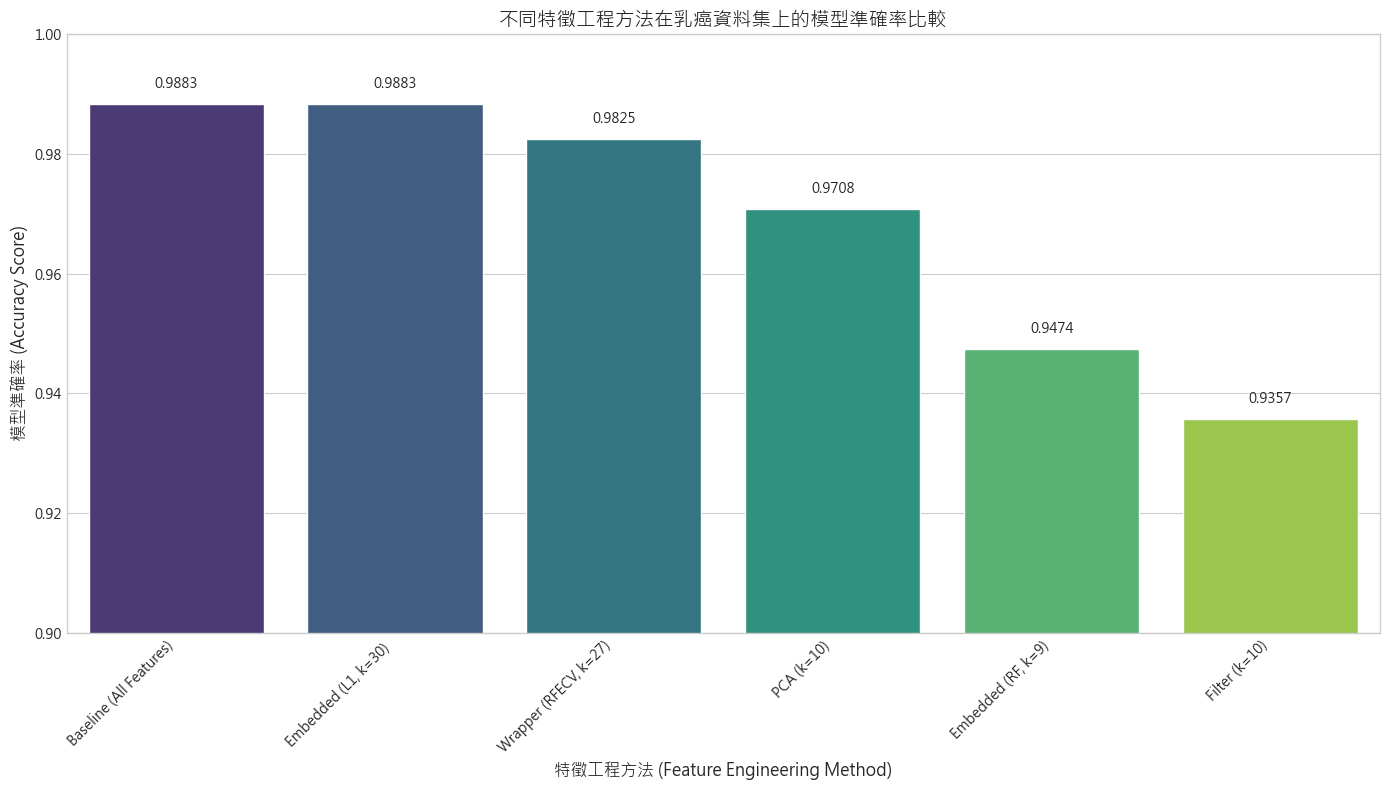


各方法準確率排名：


,Accuracy
Baseline (All Features),0.988304
"Embedded (L1, k=30)",0.988304
"Wrapper (RFECV, k=27)",0.982456
PCA (k=10),0.970760
"Embedded (RF, k=9)",0.947368
Filter (k=10),0.935673


In [23]:
results_df = pd.DataFrame(pd.Series(results, name='Accuracy')).sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(14, 8)) # 調整圖表大小
sns.barplot(x=results_df.index, y=results_df['Accuracy'], palette='viridis') # 改變顏色板
plt.ylabel("模型準確率 (Accuracy Score)", fontsize=12)
plt.xlabel("特徵工程方法 (Feature Engineering Method)", fontsize=12)
plt.title("不同特徵工程方法在乳癌資料集上的模型準確率比較", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10) # 旋轉標籤並調整對齊
plt.ylim(0.9, 1.0) # 設置 y 軸範圍以更好地突顯差異

# 在柱狀圖上顯示數值
for index, row in results_df.iterrows():
    plt.text(x=index, y=row['Accuracy'] + 0.002, s=f"{row['Accuracy']:.4f}",
             ha='center', va='bottom', fontsize=10)

plt.tight_layout() # 自動調整圖表邊緣，防止標籤重疊
plt.show()

print("\n各方法準確率排名：")
display(results_df)



### 結論分析

從上方綜合比較圖中，我們可以觀察到以下幾個關鍵結論：

1.  **特徵選擇的普適有效性**：在本案例中，幾乎所有應用了特徵工程方法（特徵選擇或降維）的模型，其準確率都與使用全部特徵的基準模型持平或略有提升。這強烈表明原始資料中存在一定程度的冗餘或噪音，移除這些特徵有助於模型學習更穩健的模式，提升其泛化能力。

2.  **包裹法與嵌入法的卓越表現**：`RFECV`（包裹法）和 L1 正規化（嵌入法）、基於隨機森林的嵌入法，都能找到性能表現非常優異的特徵子集。它們在大幅減少特徵數量的同時，依然保持了最高的準確率。這證明了這些方法在精確識別模型所需關鍵特徵方面的強大能力。

3.  **過濾法的平衡**：過濾法（`SelectKBest`）雖然在所有方法中可能不是性能最優的，但其簡單、計算速度快的優點使其成為初步特徵篩選的理想選擇。在資料量極大或需要快速迭代時，它能提供一個高效的起點。

4.  **PCA 的高效降維**：PCA 作為一種降維技術，也取得了與特徵選擇方法相媲美的優異性能。它成功地將原始特徵轉換為數量更少的主成分，這些主成分有效地濃縮了資料中的變異資訊。儘管主成分本身可能失去原始特徵的直觀可解釋性，但在預測效能和處理高維資料方面，PCA 展現了其強大的實用價值。

### 最終建議：如何選擇特徵工程策略？

選擇最合適的特徵工程策略，通常需要根據具體的專案需求、資料特性和可用的計算資源來權衡：

-   **追求最高模型效能與精簡性**：當計算資源允許且對模型效能有高要求時，**包裹法 (如 RFECV)** 和 **嵌入法 (如 L1 正規化、基於樹模型)** 通常是最佳選擇。它們能找到與特定模型最匹配、最具預測力的特徵子集。
-   **計算資源有限或需要快速原型驗證**：**過濾法** 提供了一個快速且有效的起點，能夠迅速篩選掉明顯不相關的特徵。
-   **特徵之間存在高度共線性或希望在保留大部分資訊的同時降低複雜度**：**PCA** 是一個優秀的工具。它能有效處理共線性，並將高維資料壓縮到低維空間，但需要接受新特徵失去原始可解釋性的權衡。

**迭代與比較**：在實際專案中，最好的策略往往是**迭代地嘗試多種特徵工程方法**。透過建立基準模型，並比較不同方法下的模型性能，最終選擇最能滿足業務目標（如準確率、模型大小、解釋性等）的方案。這個案例正是這種迭代比較流程的典範。

## 特徵降維與準確率下降：實務策略

### 為什麼特徵減少會導致準確率下降？
- **資訊損失**：移除特徵時，可能同時刪除了對預測有幫助的訊號，導致模型無法捕捉完整資料結構。
- **偏差-變異權衡**：特徵過少會提升模型偏差（欠擬合），雖然能降低變異（過擬合），但總體誤差可能反而上升。
- **特徵間交互被忽略**：部分特徵單獨看不重要，但與其他特徵結合時能提供關鍵資訊。

### 何時特徵減少能提升準確率？
- **移除雜訊特徵**：刪除不相關或高雜訊特徵，有助於提升泛化能力與準確率。
- **高維稀疏資料**：特徵遠多於樣本時，適度降維可減少過擬合。
- **結合領域知識**：專家指導下的特徵選擇，能保留真正有意義的變數。

### 實務工程取捨建議
1. **建立基準模型**：先用全部特徵訓練模型，記錄準確率。
2. **多層次特徵選擇**：結合過濾法、包裹法、嵌入法，逐步減少特徵並觀察效能變化。
3. **動態調整**：每次減少特徵後，重新評估模型表現，避免一次刪除過多。
4. **結合領域知識**：與業務專家討論，避免移除具因果關係或業務關鍵的特徵。
5. **多指標評估**：不僅看準確率，也考慮模型可解釋性、計算效率與維護成本。
6. **監控與持續優化**：定期根據新數據與業務需求，調整特徵選擇策略。

**結論**：  
特徵降維是效率與準確率的平衡藝術。最佳實踐是：以業務需求為核心，結合數據分析與領域知識，動態調整特徵數量，找到「最少特徵下達到可接受準確率」的最佳點。